In [80]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from models import MultiResUNet1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from keras.models import load_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [81]:
# Load in preProcessed data
PPG_seq = np.load("PPG_seq.npy")
ECG_seq = np.load("ECG_seq.npy")
ABP_seq = np.load("ABP_seq.npy")

# Check data shape
print(ABP_seq.shape)

(492135, 256, 1)


In [82]:
# Extract SBP and DBP from each segment

SBPs = []
DBPs = []
idds = []
for i, seq in enumerate(ABP_seq):
    # Remove padded zeros
    trim = np.trim_zeros(seq)
    
    SBP = np.max(trim) # Systolic Blood Pressure is the max value of the BP signal
    
    # Remove a few cases of erroneous data without defined peaks
    if abs(SBP - 148.0167398) < 0.01 or abs(SBP - 185.02146698) < 0.01:
        idds.append(i) # Mark data for deletion
    else:
        SBPs.append(SBP)
        DBP = np.min(trim) # Diastolic Blood Pressure is the max value of the BP signal
        DBPs.append(DBP)

SBPs = np.array(SBPs)
DBPs = np.array(DBPs)

# Delete the marked data
PPG_seq = np.delete(PPG_seq,idds,axis=0)
ECG_seq = np.delete(ECG_seq,idds,axis=0)
ABP_seq = np.delete(ABP_seq,idds,axis=0)

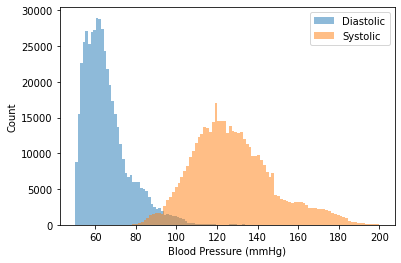

In [83]:
# Plot the DBP and SBP distrubutions
plt.hist(DBPs,bins=100,alpha=0.5);
plt.hist(SBPs,bins=100,alpha=0.5);
plt.legend(["Diastolic","Systolic"]);
plt.ylabel("Count");
plt.xlabel("Blood Pressure (mmHg)");

In [84]:
# Combine PPG and ECG data for the 2 channel model
comb = np.append(PPG_seq,ECG_seq,axis=2)
comb.shape

(478306, 256, 2)

In [85]:
# Split data into training and test sets
# RAM for this kernel was only able to support 300,000 sequences
X_train, X_test, y_train, y_test = train_test_split(comb[:300000], ABP_seq[:300000], test_size=0.1, random_state=42)

# Used when training on 1 channel model (PPG only)
# X_train, X_test, y_train, y_test = train_test_split(PPG_seq[:300000], ABP_seq[:300000], test_size=0.1, random_state=42)

In [ ]:
# Create model and compile
model = MultiResUNet1D(256,2)
opt = Adam(learning_rate=1e-5)
model.compile(optimizer=opt, loss='mse')

In [ ]:
# Train model with early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test,y_test),
    epochs=1000,
    verbose=1,
    callbacks=[es])

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Save model
#model.save("1ChMultiResUNet.h5")
#model.save("2ChMultiResUNet.h5")

# PPG + ECG Model Performance

In [7]:
# Load 2 channel model
model = load_model("2ChMultiResUNet.h5")

In [10]:
# Predict the test dataset
pred = model.predict(X_test)

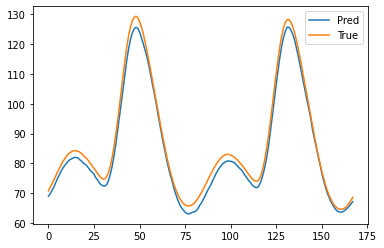

In [11]:
# Display actual vs. predicted for a chosen sample
num = 0
ytrim = np.trim_zeros(y_test[num])
ptrim = pred[num][0:len(ytrim)]
plt.plot(ptrim)
plt.plot(ytrim)
plt.legend(["Pred","True"])

In [12]:
# For each sequence obtain the true DBP, SBP, MAP
# For each sequence obtain the predicted DBP, SBP, MAP
# Compute the RMSE between the true and predicted waveforms

tDBPs = []
tSBPs = []
tMAPs = []
pDBPs = []
pSBPs = []
pMAPs = []
RMSEs = []

for i, seq in enumerate(y_test):
    truth_trim = np.trim_zeros(seq)
    ln = len(truth_trim)
    
    pred_trim = pred[i][:ln]
    
    truth_SBP = np.max(truth_trim)
    tSBPs.append(truth_SBP)
    truth_DBP = np.min(truth_trim)
    tDBPs.append(truth_DBP)
    truth_MAP = np.mean(truth_trim)
    tMAPs.append(truth_MAP)
    
    pred_SBP = np.max(pred_trim)
    pSBPs.append(pred_SBP)
    pred_DBP = np.min(pred_trim)
    pDBPs.append(pred_DBP)
    pred_MAP = np.mean(pred_trim)
    pMAPs.append(pred_MAP)
    
    RMSEs.append(mean_squared_error(truth_trim,pred_trim,squared=False))

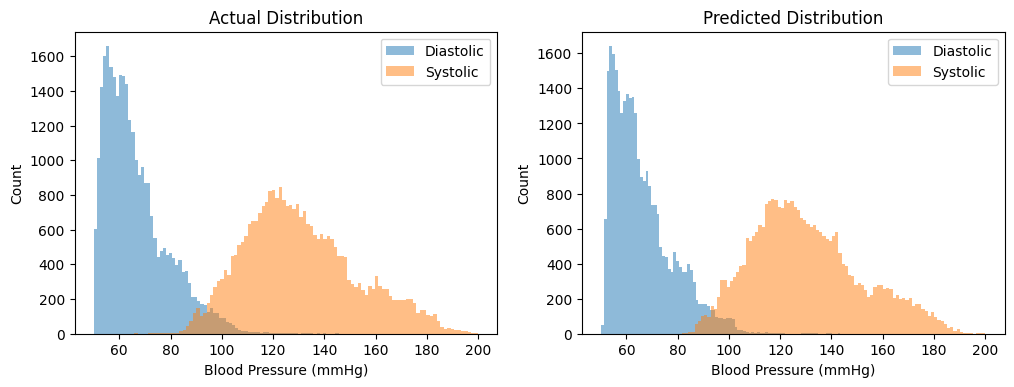

In [37]:
# Plot the DBP and SBP distrubutions of the test data
plt.figure(figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.title("Actual Distribution")
plt.hist(tDBPs,bins=100,alpha=0.5);
plt.hist(tSBPs,bins=100,alpha=0.5);
plt.legend(["Diastolic","Systolic"]);
plt.ylabel("Count");
plt.xlabel("Blood Pressure (mmHg)");
plt.subplot(122)
plt.title("Predicted Distribution")
plt.hist(pDBPs,bins=100,alpha=0.5);
plt.hist(pSBPs,bins=100,alpha=0.5);
plt.legend(["Diastolic","Systolic"]);
plt.ylabel("Count");
plt.xlabel("Blood Pressure (mmHg)");

DBP:
R2 0.94305789067202
RMSE 2.976684149896031 

SBP:
R2 0.9524245457419668
RMSE 4.778826248758403 

MAP:
R2 0.9664589667949485
RMSE 2.612826859253135 



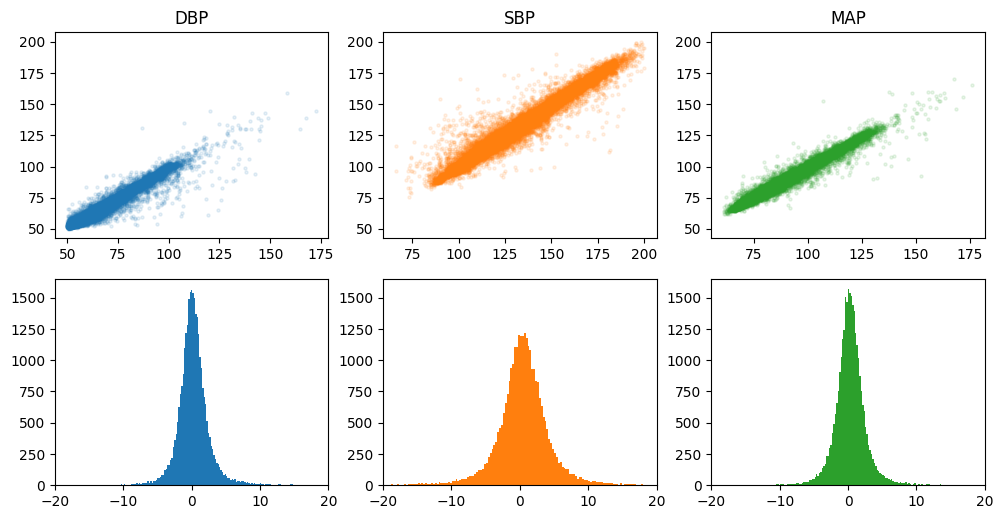

In [58]:
plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')

ax1 = plt.subplot(231)
plt.title("DBP")
plt.scatter(tDBPs,pDBPs,s=5,alpha=0.1);
print("DBP:")
print("R2", r2_score(tDBPs,pDBPs))
print("RMSE", mean_squared_error(tDBPs,pDBPs,squared=False),"\n")

ax2 = plt.subplot(234)
plt.hist(np.array(tDBPs)-np.array(pDBPs),bins=500);
plt.xlim((-20,20));

plt.subplot(232, sharey= ax1)
plt.title("SBP")
plt.scatter(tSBPs,pSBPs,s=5,alpha=0.1, color="tab:orange")
print("SBP:")
print("R2", r2_score(tSBPs,pSBPs))
print("RMSE", mean_squared_error(tSBPs,pSBPs,squared=False),"\n")

plt.subplot(235, sharey= ax2)
plt.hist(np.array(tSBPs)-np.array(pSBPs),bins=500, color="tab:orange");
plt.xlim((-20,20));

plt.subplot(233, sharey= ax1)
plt.title("MAP")
plt.scatter(tMAPs,pMAPs,s=5,alpha=0.1, color="tab:green")
print("MAP:")
print("R2", r2_score(tMAPs,pMAPs))
print("RMSE", mean_squared_error(tMAPs,pMAPs,squared=False),"\n")

plt.subplot(236, sharey= ax2)
plt.hist(np.array(tMAPs)-np.array(pMAPs),bins=500, color="tab:green");
plt.xlim((-20,20));

In [22]:
tClass = []
pClass = []

# Classifications
    # 0 - Normal
    # 1 - Elevated
    # 2 - Hyper 1
    # 3 - Hyper 2

for i in range(len(tSBPs)):
    if (tSBPs[i] > 140) or (tDBPs[i] > 90):
        tClass.append(3)
    elif (tSBPs[i] > 130 and tSBPs[i] < 140) or (tDBPs[i] > 80 and tDBPs[i] < 90):
        tClass.append(2)
    elif (tSBPs[i] > 120 and tSBPs[i] < 130) and (tDBPs[i] < 80):
        tClass.append(1)
    elif (tSBPs[i] < 120) and (tDBPs[i] < 80):
        tClass.append(0)
    else:
        tClass.append(0)
        
    if (pSBPs[i] > 140) or (pDBPs[i] > 90):
        pClass.append(3)
    elif (pSBPs[i] > 130 and pSBPs[i] < 140) or (pDBPs[i] > 80 and pDBPs[i] < 90):
        pClass.append(2)
    elif (pSBPs[i] > 120 and pSBPs[i] < 130) and (pDBPs[i] < 80):
        pClass.append(1)
    elif (pSBPs[i] < 120) and (pDBPs[i] < 80):
        pClass.append(0)
    else:
        pClass.append(0)

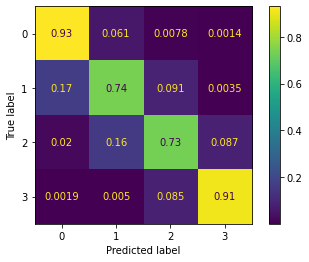

In [23]:
cm = confusion_matrix(tClass,pClass,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

In [24]:
tSClass = []
tDClass = []
pSClass = []
pDClass = []

for i in (range(len(tDBPs))):

        if(tDBPs[i] <= 80):
            tDClass.append('Normotension')
        elif((tDBPs[i] > 80)and(tDBPs[i] <= 90)):
            tDClass.append('Pre-hypertension')
        elif(tDBPs[i] > 90):
            tDClass.append('Hypertension')
        else:
            print('bump')

        if(pDBPs[i] <= 80):
            pDClass.append('Normotension')
        elif((pDBPs[i] > 80)and(pDBPs[i] <= 90)):
            pDClass.append('Pre-hypertension')
        elif(pDBPs[i] > 90):
            pDClass.append('Hypertension')
        else:
            print('bump')
            
for i in (range(len(tSBPs))):

        if(tSBPs[i] <= 120):
            tSClass.append('Normotension')
        elif((tSBPs[i] > 120)and(tSBPs[i] <= 140)):
            tSClass.append('Pre-hypertension')
        elif(tSBPs[i] > 140):
            tSClass.append('Hypertension')
        else:
            print('bump')

        if(pSBPs[i] <= 120):
            pSClass.append('Normotension')
        elif((pSBPs[i] > 120)and(pSBPs[i] <= 140)):
            pSClass.append('Pre-hypertension')
        elif(pSBPs[i] > 140):
            pSClass.append('Hypertension')
        else:
            print('bump')

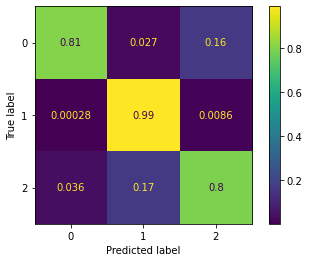

In [60]:
cm = confusion_matrix(tDClass,pDClass,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

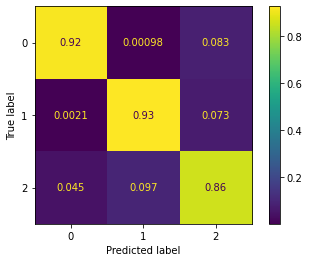

In [61]:
cm = confusion_matrix(tSClass,pSClass,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

# PPG Only Model Performance

In [62]:
model = load_model("1ChMultiResUNet.h5")
X_train, X_test, y_train, y_test = train_test_split(PPG_seq[:300000], ABP_seq[:300000], test_size=0.1, random_state=42)

In [63]:
pred = model.predict(X_test)

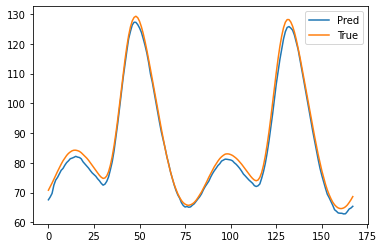

In [64]:
num = 0

ytrim = np.trim_zeros(y_test[num])
ptrim = pred[num][0:len(ytrim)]
plt.plot(ptrim)
plt.plot(ytrim)
plt.legend(["Pred","True"])

In [65]:
tDBPs = []
tSBPs = []
tMAPs = []
pDBPs = []
pSBPs = []
pMAPs = []
RMSEs = []

for i, seq in enumerate(y_test):
    truth_trim = np.trim_zeros(seq)
    ln = len(truth_trim)
    
    pred_trim = pred[i][:ln]
    
    truth_SBP = np.max(truth_trim)
    tSBPs.append(truth_SBP)
    # [int(len(truth_trim)/20):int(19*(len(truth_trim)/20))]
    truth_DBP = np.min(truth_trim)
    tDBPs.append(truth_DBP)
    truth_MAP = np.mean(truth_trim)
    tMAPs.append(truth_MAP)
    
    pred_SBP = np.max(pred_trim)
    pSBPs.append(pred_SBP)
    # [int(len(truth_trim)/20):int(19*(len(pred_trim)/20))]
    pred_DBP = np.min(pred_trim)
    pDBPs.append(pred_DBP)
    pred_MAP = np.mean(pred_trim)
    pMAPs.append(pred_MAP)
    
    RMSEs.append(mean_squared_error(truth_trim,pred_trim,squared=False))

In [66]:
# Plot the DBP and SBP distrubutions of the test data
plt.figure(figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.title("Actual Distribution")
plt.hist(tDBPs,bins=100,alpha=0.5);
plt.hist(tSBPs,bins=100,alpha=0.5);
plt.legend(["Diastolic","Systolic"]);
plt.ylabel("Count");
plt.xlabel("Blood Pressure (mmHg)");
plt.subplot(122)
plt.title("Predicted Distribution")
plt.hist(pDBPs,bins=100,alpha=0.5);
plt.hist(pSBPs,bins=100,alpha=0.5);
plt.legend(["Diastolic","Systolic"]);
plt.ylabel("Count");
plt.xlabel("Blood Pressure (mmHg)");

DBP:
R2 0.878068475530377
RMSE 4.355860687597872 

SBP:
R2 0.8964857797928784
RMSE 7.049036771190583 

MAP:
R2 0.9245265124677112
RMSE 3.9194003123273244 



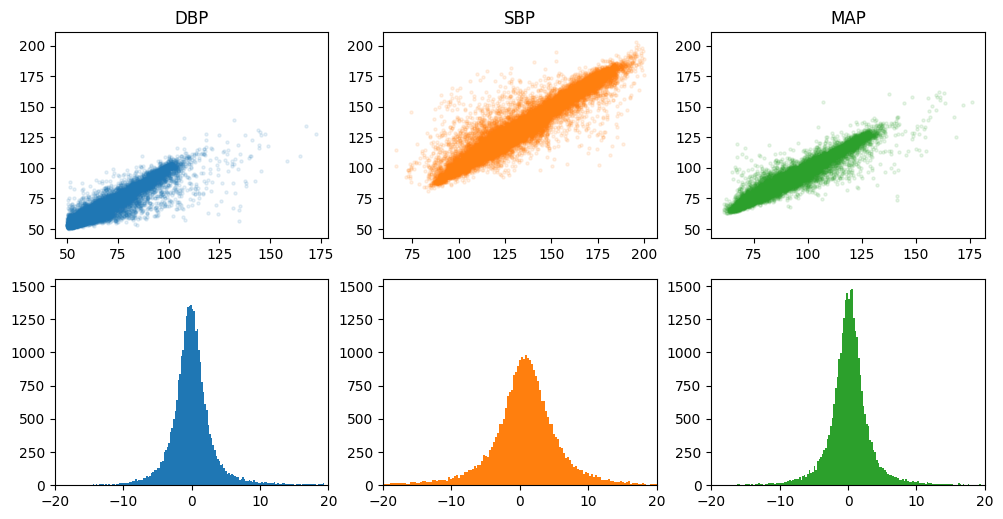

In [67]:
plt.figure(figsize=(12,6), dpi= 100, facecolor='w', edgecolor='k')

ax1 = plt.subplot(231)
plt.title("DBP")
plt.scatter(tDBPs,pDBPs,s=5,alpha=0.1);
print("DBP:")
print("R2", r2_score(tDBPs,pDBPs))
print("RMSE", mean_squared_error(tDBPs,pDBPs,squared=False),"\n")

ax2 = plt.subplot(234)
plt.hist(np.array(tDBPs)-np.array(pDBPs),bins=500);
plt.xlim((-20,20));

plt.subplot(232, sharey= ax1)
plt.title("SBP")
plt.scatter(tSBPs,pSBPs,s=5,alpha=0.1, color="tab:orange")
print("SBP:")
print("R2", r2_score(tSBPs,pSBPs))
print("RMSE", mean_squared_error(tSBPs,pSBPs,squared=False),"\n")

plt.subplot(235, sharey= ax2)
plt.hist(np.array(tSBPs)-np.array(pSBPs),bins=500, color="tab:orange");
plt.xlim((-20,20));

plt.subplot(233, sharey= ax1)
plt.title("MAP")
plt.scatter(tMAPs,pMAPs,s=5,alpha=0.1, color="tab:green")
print("MAP:")
print("R2", r2_score(tMAPs,pMAPs))
print("RMSE", mean_squared_error(tMAPs,pMAPs,squared=False),"\n")

plt.subplot(236, sharey= ax2)
plt.hist(np.array(tMAPs)-np.array(pMAPs),bins=500, color="tab:green");
plt.xlim((-20,20));

In [68]:
tClass = []
pClass = []

# Classifications
    # 0 - Normal
    # 1 - Elevated
    # 2 - Hyper 1
    # 3 - Hyper 2

for i in range(len(tSBPs)):
    if (tSBPs[i] > 140) or (tDBPs[i] > 90):
        tClass.append(3)
    elif (tSBPs[i] > 130 and tSBPs[i] < 140) or (tDBPs[i] > 80 and tDBPs[i] < 90):
        tClass.append(2)
    elif (tSBPs[i] > 120 and tSBPs[i] < 130) and (tDBPs[i] < 80):
        tClass.append(1)
    elif (tSBPs[i] < 120) and (tDBPs[i] < 80):
        tClass.append(0)
    else:
        tClass.append(0)
        
    if (pSBPs[i] > 140) or (pDBPs[i] > 90):
        pClass.append(3)
    elif (pSBPs[i] > 130 and pSBPs[i] < 140) or (pDBPs[i] > 80 and pDBPs[i] < 90):
        pClass.append(2)
    elif (pSBPs[i] > 120 and pSBPs[i] < 130) and (pDBPs[i] < 80):
        pClass.append(1)
    elif (pSBPs[i] < 120) and (pDBPs[i] < 80):
        pClass.append(0)
    else:
        pClass.append(0)

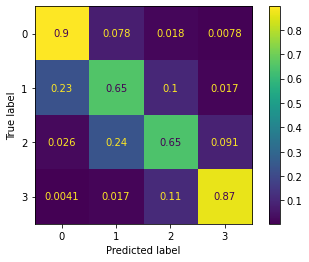

In [69]:
cm = confusion_matrix(tClass,pClass,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

In [70]:
tSClass = []
tDClass = []
pSClass = []
pDClass = []

for i in (range(len(tDBPs))):

        if(tDBPs[i] <= 80):
            tDClass.append('Normotension')
        elif((tDBPs[i] > 80)and(tDBPs[i] <= 90)):
            tDClass.append('Pre-hypertension')
        elif(tDBPs[i] > 90):
            tDClass.append('Hypertension')
        else:
            print('bump')

        if(pDBPs[i] <= 80):
            pDClass.append('Normotension')
        elif((pDBPs[i] > 80)and(pDBPs[i] <= 90)):
            pDClass.append('Pre-hypertension')
        elif(pDBPs[i] > 90):
            pDClass.append('Hypertension')
        else:
            print('bump')
            
for i in (range(len(tSBPs))):

        if(tSBPs[i] <= 120):
            tSClass.append('Normotension')
        elif((tSBPs[i] > 120)and(tSBPs[i] <= 140)):
            tSClass.append('Pre-hypertension')
        elif(tSBPs[i] > 140):
            tSClass.append('Hypertension')
        else:
            print('bump')

        if(pSBPs[i] <= 120):
            pSClass.append('Normotension')
        elif((pSBPs[i] > 120)and(pSBPs[i] <= 140)):
            pSClass.append('Pre-hypertension')
        elif(pSBPs[i] > 140):
            pSClass.append('Hypertension')
        else:
            print('bump')

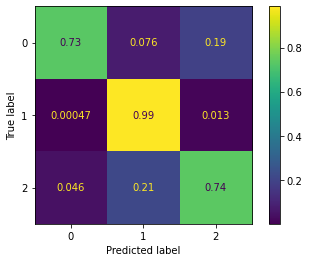

In [71]:
cm = confusion_matrix(tDClass,pDClass,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

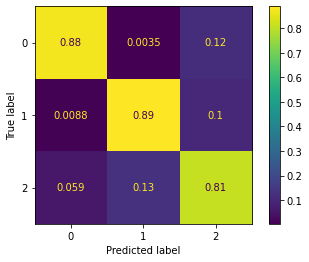

In [72]:
cm = confusion_matrix(tSClass,pSClass,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

# Animated Demo

In [78]:
model1 = load_model("1ChMultiResUNet.h5")
model2 = load_model("2ChMultiResUNet.h5")

In [86]:
X_train, X_test, y_train, y_test = train_test_split(comb[:300000], ABP_seq[:300000], test_size=0.1, random_state=42)

pred1 = model1.predict(np.reshape(X_test[:,:,0],(30000,256,1))[:50])
pred2 = model2.predict(X_test[:50])

In [87]:
ltruth = np.empty((0,))
lpred1 = np.empty((0,))
lpred2 = np.empty((0,))
lECG = np.empty((0,))
lPPG = np.empty((0,))

for i in range(len(pred1)):
    ttrim = np.trim_zeros(y_test[i])
    ttrim = np.reshape(ttrim, (len(ttrim)))
    
    ptrim1 = pred1[i][:len(ttrim)]
    ptrim1 = np.reshape(ptrim1, (len(ptrim1)))
    ptrim2 = pred2[i][:len(ttrim)]
    ptrim2 = np.reshape(ptrim2, (len(ptrim2)))
    
    ecgtrim = X_test[i][:,1][:len(ttrim)]
    ecgtrim = np.reshape(ecgtrim, (len(ecgtrim)))
    
    ppgtrim = X_test[i][:,0][:len(ttrim)]
    ppgtrim = np.reshape(ppgtrim, (len(ppgtrim)))
    
    ltruth = np.concatenate((ltruth, ttrim))
    lpred1 = np.concatenate((lpred1, ptrim1))
    lpred2 = np.concatenate((lpred2, ptrim2))
    lECG = np.concatenate((lECG, ecgtrim))
    lPPG = np.concatenate((lPPG, ppgtrim))

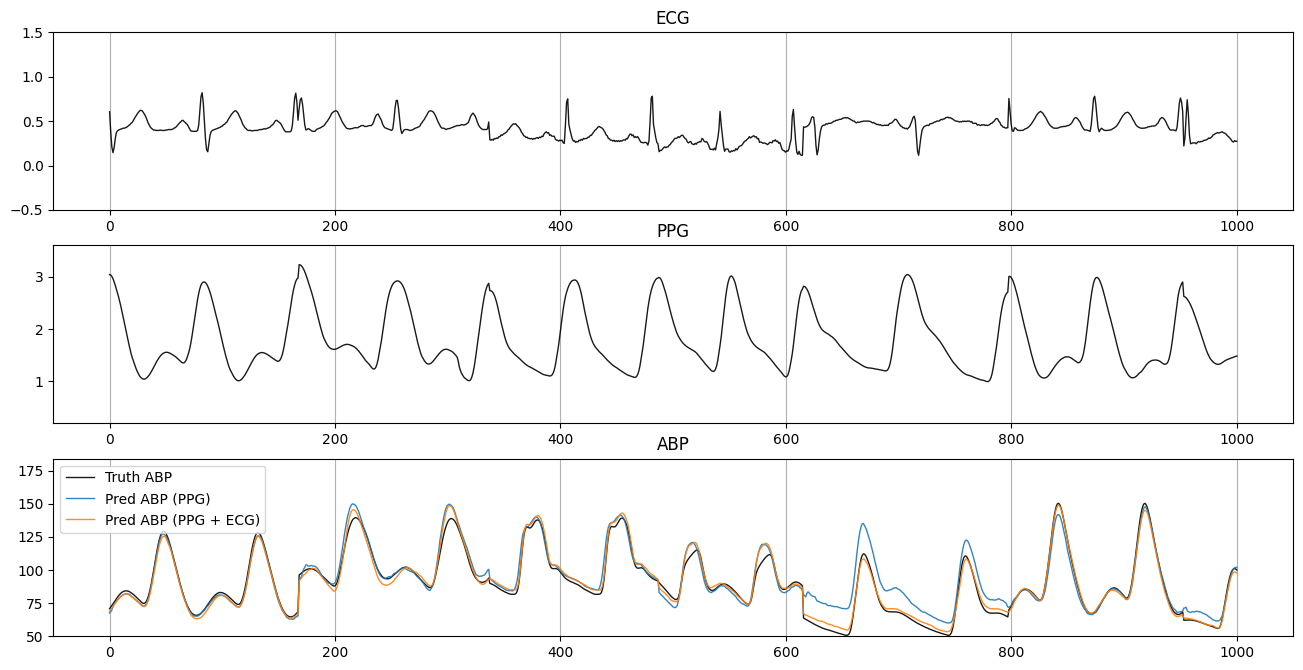

In [88]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

line1, = ax1.plot([], [], lw=1, color='k', alpha=0.9)
line2, = ax2.plot([], [], lw=1, color='k', alpha=0.9)
line3, = ax3.plot([], [], lw=1, color='k', alpha=0.9)
line4, = ax3.plot([], [], lw=1, alpha=0.9)
line5, = ax3.plot([], [], lw=1, alpha=0.9)
line = [line1, line2, line3, line4, line5]

ax1.set_ylim(-0.5, 1.5)
ax1.set_xlim(-50, 1050)
ax1.grid(which='major',axis='x')
ax1.set_title("ECG")

ax2.set_ylim(0.2, 3.6)
ax2.set_xlim(-50, 1050)
ax2.grid(which='major',axis='x')
ax2.set_title("PPG")

ax3.set_ylim(50, 184)
ax3.set_xlim(-50, 1050)
ax3.grid(which='major',axis='x')
ax3.legend(["Truth ABP","Pred ABP (PPG)","Pred ABP (PPG + ECG)"],loc='upper left')
ax3.set_title("ABP")

def run(i):
    x = np.linspace(0, 1000, 1000)
    
    y1 = lECG[i:1000+i]
    y2 = lPPG[i:1000+i]
    y3 = ltruth[i:1000+i]
    y4 = lpred1[i:1000+i]
    y5 = lpred2[i:1000+i]
    
    line[0].set_data(x, y1)
    line[1].set_data(x, y2)
    line[2].set_data(x, y3)
    line[3].set_data(x, y4)
    line[4].set_data(x, y5)

    return line

ani = animation.FuncAnimation(fig, run, blit=True, frames=2000, interval=10)

In [89]:
HTML(ani.to_html5_video())